In [2]:
import os
import glob
import pandas as pd
import numpy as np

from utilities import load_data_using_multithreading, retrieve_list_of_tif

In [51]:
input_folder = "/SNS/VENUS/IPTS-33699/shared/autoreduce/mcp/November13_2024_Baseline_OB_2_0C_0_7Ang_min"
run_number = "Run_4861"

input_folder = "/SNS/VENUS/IPTS-33699/shared/autoreduce/mcp/Octobe12_2024_Ni_5_0C_1_9_Angs_min"
run_number = "Run_3804"

assert os.path.exists(input_folder)

Define shutter count file

In [52]:
shutter_counts = glob.glob(os.path.join(input_folder, run_number, "*ShutterCount.txt"))
assert len(shutter_counts) == 1
shutter_count_file = shutter_counts[0]

This file looks like
```
0   10612
1   10011
2   10445
3   107962
4   10864   
5   10252   
6   0
7   0
...
```

Define shutter time file

In [53]:
shutter_times = glob.glob(os.path.join(input_folder, run_number, "*ShutterTimes.txt"))
assert len(shutter_times) == 1
shutter_time_file = shutter_times[0]

This file looks like
```
0   0.0001  0.00690176
1   0.00039824  0.00559104
2   0.00040256  0.00559104
3   0.00040896  0.00919552
4   0.00040448  0.00299008
5   0.00040992  0.00159744
6   0   0   
...
```

Define time spectra file

In [54]:
time_spectra = glob.glob(os.path.join(input_folder, run_number, "*_Spectra.txt"))
assert len(time_spectra) == 1
time_spectra_file = time_spectra[0]

This file looks like
```
1 shutter_time,counts
2 0.00012048,175494
3 0.00014096,187903
4 0.00016144,201185
...
```

# Plan

First task will be to figure out which frame each image belongs to using __*\_Spectra.txt__ file.

This file gives each image its time frame. The code will look in the **ShutterTimes** file to figure out which time frame it belongs to, and then which coefficient to use in the **shutter_count_file**

# Load shutter counts

In [55]:
pd_shutter_count = pd.read_csv(shutter_count_file, sep="\t", header=None, names=["shutter_count"])

# keep only the shutter counts that are greater than 0
pd_shutter_count = pd_shutter_count[pd_shutter_count["shutter_count"] > 0]
print(pd_shutter_count)

   shutter_count
0         210434
1         210606
2         210212


# Load shutter values

In [56]:
pd_shutter_time = pd.read_csv(shutter_time_file, sep="\t", header=None, names=['from', 'to'])

# keep only the shutter values that are greater than 0
pd_shutter_time = pd_shutter_time[pd_shutter_time["to"] > 0]
print(pd_shutter_time)

           from        to
0  9.600000e-07  0.002499
1  4.004800e-04  0.005100
2  3.217600e-04  0.007578


In [57]:
pd_shutter_values = np.array(pd_shutter_time).flatten().cumsum().reshape(pd_shutter_time.shape)
print(pd_shutter_values)

[[9.600000e-07 2.499520e-03]
 [2.900000e-03 7.999520e-03]
 [8.321280e-03 1.589888e-02]]


# Load spectra file

In [58]:
pd_spectra_file = pd.read_csv(time_spectra_file, sep=",", skiprows=1, names=["time", "counts"])
#print(pd_spectra_file)
spectra_index = np.array(pd_spectra_file["time"])

In [59]:
spectra_index

array([1.12000e-05, 2.14400e-05, 3.16800e-05, ..., 1.58477e-02,
       1.58579e-02, 1.58682e-02])

In [60]:
list_index_with_shutter_values = []

for index, _time in enumerate(spectra_index):
    found_shutter_value = False
    for _shutter_undex, (_from_time, _to_time) in enumerate(pd_shutter_values):
        print(f"{_from_time =} and {_to_time =} looking at {_time =}")
        if _time >= _from_time and _time <= _to_time:
            list_index_with_shutter_values.append(_shutter_undex)
            found_shutter_value = True
            break
    if found_shutter_value is False:
        raise ValueError(f"Could not find a shutter value for time {_time}")    

_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =1.12e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =2.144e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =3.168e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =4.192e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =5.216e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =6.24e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =7.264e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =8.288e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =9.312e-05
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =0.00010336
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =0.0001136
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =0.00012384
_from_time =9.6e-07 and _to_time =0.00249952 looking at _time =0.00013408
_from_time =9.6e-07 and _to_time =0.00249952 looki

In [61]:
import matplotlib.pyplot as plt


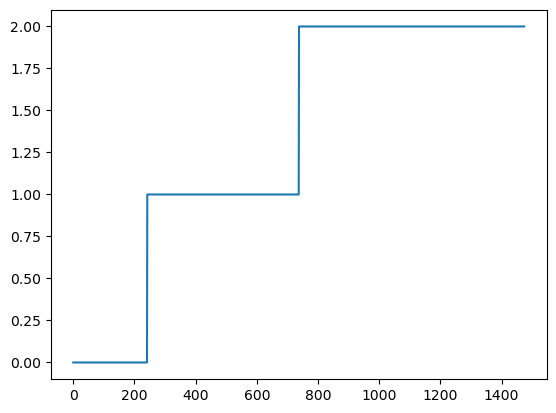

In [62]:
plt.figure()
plt.plot(list_index_with_shutter_values)

# Load the stack of images

In [63]:
list_tiff = retrieve_list_of_tif(os.path.join(input_folder, run_number))
assert len(list_tiff) > 0

In [64]:
images = load_data_using_multithreading(list_tiff)


# Divide each image by the corresponding number of frames

In [65]:
images_corrected = []
for _index, _image in enumerate(images):
    correction_factor = pd_shutter_count["shutter_count"][int(list_index_with_shutter_values[_index])]
    images_corrected.append(_image / correction_factor) 

In [66]:
profile_before = np.sum(np.array(images), axis=(1, 2))
profile_after = np.sum(np.array(images_corrected), axis=(1, 2))

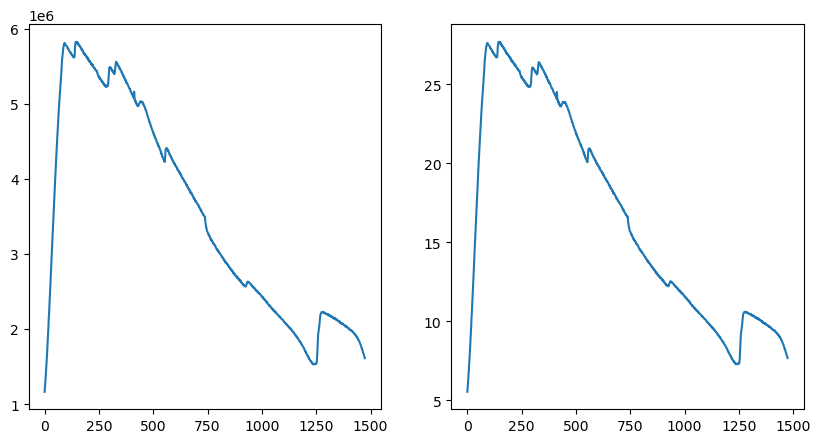

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].plot(profile_before, label="Before")
axs[1].plot(profile_after, label="After")

Trying to compare the two by scaling the right plot to the left plot max value

In [68]:
max_left = np.max(profile_before)
max_right = np.max(profile_after)

In [69]:
compare_factor = max_left / max_right

In [70]:
scale_profile_after = profile_after * compare_factor

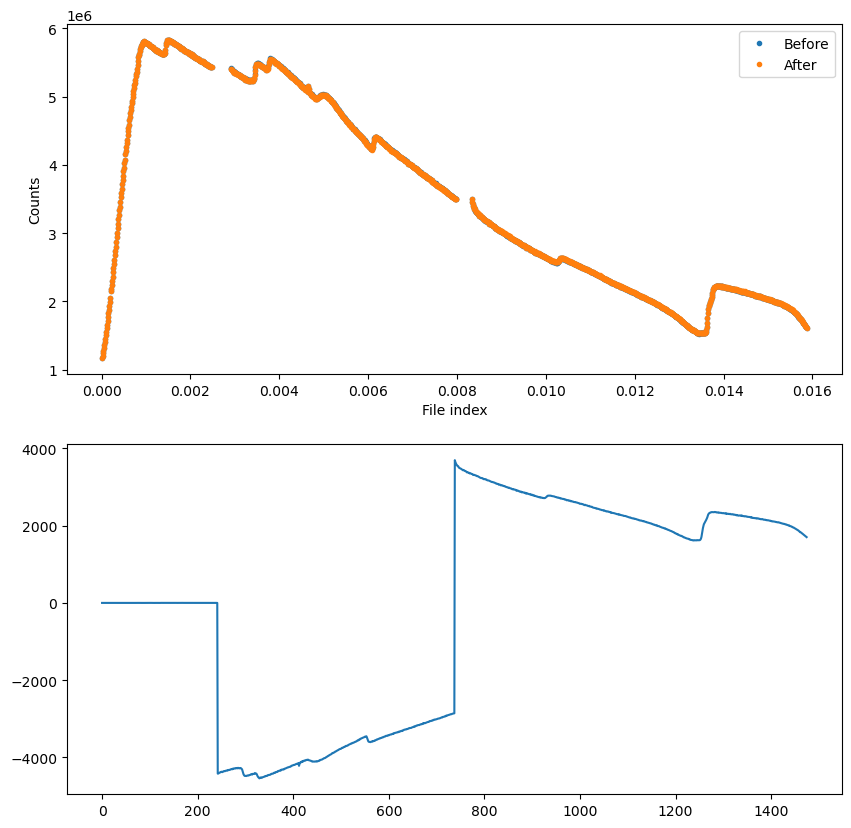

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axs[0].plot(spectra_index, profile_before, label="Before", marker=".", linestyle="")
axs[0].set_xlabel("File index")
axs[0].set_ylabel("Counts")
axs[0].plot(spectra_index, scale_profile_after, label="After", marker=".", linestyle="")
axs[0].legend()

axs[1].plot(scale_profile_after - profile_before, label="After - Before")

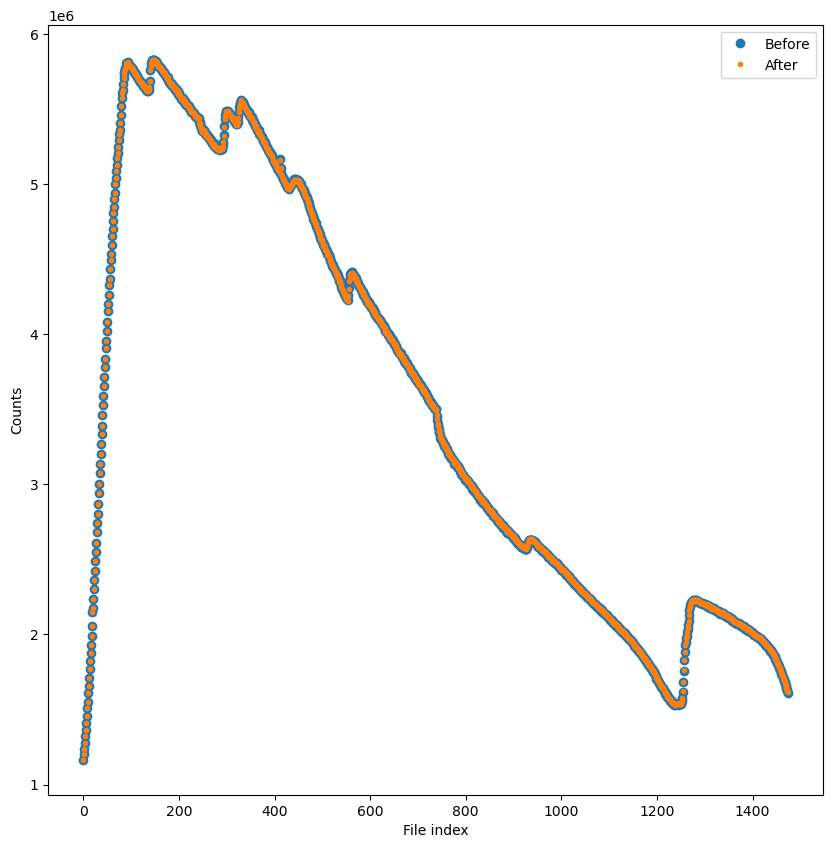

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
axs.plot(profile_before, label="Before", marker="o", linestyle="")
axs.set_xlabel("File index")
axs.set_ylabel("Counts")
axs.plot(scale_profile_after, label="After", marker=".", linestyle="")
axs.legend()